In [1]:
import numpy as np
import pandas as pd
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO, MCMC, NUTS

import torch
from torch.distributions import constraints

import matplotlib.pyplot as plt
import seaborn as sns

import graphviz


In [30]:
def beamProperties():
        beam = {"length": 0.301,
            "width": 0.026,
            "thickness": 0.003,
            
            "E": 10e11,
            
            "mass": 0.1877
            }

        beam["massPerUnit"] = beam["mass"] / beam["length"]
        beam["volume"] = beam["length"] * beam["width"] * beam["thickness"]
        beam["I"] = beam["width"]*beam["thickness"]**3/12
        return beam

def mobilityFuncModel(E, eta=0.1):
    beam = beamProperties()
    l = beam["length"]/2

    w = 2*np.pi*freq
    B = E*beam["I"]
    complex_B = E*(1+1j*eta)*beam["I"]
    cb = np.sqrt(w)*(B/beam["massPerUnit"])**(1/4)
    kl = w/cb*l

    complex_kl = kl*(1-1j*eta/4)
    
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    #Y = -(0.25*eta+1j)*l/(2*kl*np.sqrt(B*beam["massPerUnit"])) * N_l/D_l
    Y = abs(-1j*l/ (2*complex_kl*np.sqrt(complex_B*beam["massPerUnit"])) * N_l/D_l)
    #Y = Y/max(Y)
    return Y

def mobilityFuncModelx(E, freq, rho=8.4e-3, eta=0.007):
    """
    Calculates the mobility value based on the Young's modulus(E) and the frequency
    Input: 
        E   : Young's modulus
        eta : loss factor
    Output: 
        Y   : Mobility value
    """
    l = beam["length"]/2

    # calculating the bending wave number
    w = 2*np.pi*freq # Angular frequency
    B = E*beam["I"] #
    complex_B = E*(1+1j*eta)*beam["I"]
    massPerUnit = rho*beam["thickness"]*beam["width"]
    cb = np.sqrt(w)*(B/massPerUnit)**(1/4) # bending wave velocity
    
    kl = w/(cb)*l # bending wave number
    complex_kl = kl*(1-1j*eta/4)
    N_l = np.cos(complex_kl)*np.cosh(complex_kl) + 1
    D_l = np.cos(complex_kl)*np.sinh(complex_kl) + np.sin(complex_kl)*np.cosh(complex_kl)

    Y = -(1j*l)/ (2*complex_kl*np.sqrt(complex_B *massPerUnit)) * N_l/D_l
    return abs(Y)

In [33]:
beam = beamProperties()

experiment = pd.read_csv("./Data/bend/centerFreqResponse.csv")[20:]
Y_exp = abs(experiment["force"].values + 1j*experiment["velocity"].values)
Y_exp_norm = (Y_exp - Y_exp.mean()) / Y_exp.std()
freq = experiment["freq"].values
Y_theo = mobilityFuncModelx(1*10e10, freq, rho=0.65*8.4e3,eta=0.9*0.01)
freq = experiment["freq"].values

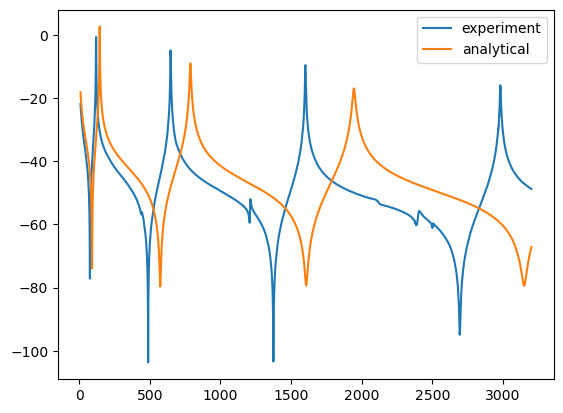

In [70]:
plt.plot(freq, 20*np.log10(Y_exp), label="experiment")
plt.plot(freq, 20*np.log10(Y_theo), label="analytical")
plt.legend()

In [13]:
len(freq)

6381

In [2]:
from scipy.signal import find_peaks
experiment = pd.read_csv("./Data/bend/centerFreqResponse.csv")[20:]
Y_exp = abs(experiment["force"].values + 1j*experiment["velocity"].values)
freq = experiment["freq"].values



In [3]:
resonances, _ = find_peaks(Y_exp, prominence=0.1)
print(resonances)

[ 220 1274 3181 5939]


Text(0.5, 0, 'Frequency / Hz')

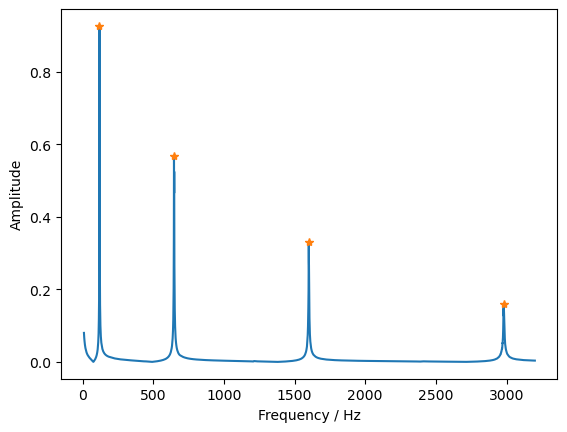

In [5]:
plt.plot(freq, Y_exp)
plt.plot(freq[resonances],Y_exp[resonances], '*' )
plt.ylabel("Amplitude")
plt.xlabel("Frequency / Hz")


In [52]:
comsolArray = np.array([])
comsolArray
comsolArray = np.append(comsolArray, np.arange(freq[resonances[0]]-5, freq[resonances[0]]+5, 0.5))
comsolArray

array([115. , 115.5, 116. , 116.5, 117. , 117.5, 118. , 118.5, 119. ,
       119.5, 120. , 120.5, 121. , 121.5, 122. , 122.5, 123. , 123.5,
       124. , 124.5])

In [6]:
comsolArray = np.array([])
for resonance in resonances:
    comsolArray = np.append(comsolArray, np.arange(freq[resonance]-5, freq[resonance]+5, 0.5))
print(comsolArray)

[ 115.   115.5  116.   116.5  117.   117.5  118.   118.5  119.   119.5
  120.   120.5  121.   121.5  122.   122.5  123.   123.5  124.   124.5
  642.   642.5  643.   643.5  644.   644.5  645.   645.5  646.   646.5
  647.   647.5  648.   648.5  649.   649.5  650.   650.5  651.   651.5
 1595.5 1596.  1596.5 1597.  1597.5 1598.  1598.5 1599.  1599.5 1600.
 1600.5 1601.  1601.5 1602.  1602.5 1603.  1603.5 1604.  1604.5 1605.
 2974.5 2975.  2975.5 2976.  2976.5 2977.  2977.5 2978.  2978.5 2979.
 2979.5 2980.  2980.5 2981.  2981.5 2982.  2982.5 2983.  2983.5 2984. ]


In [13]:
freq[np.isin(freq, comsolArray)]

array([ 115. ,  115.5,  116. ,  116.5,  117. ,  117.5,  118. ,  118.5,
        119. ,  119.5,  120. ,  120.5,  121. ,  121.5,  122. ,  122.5,
        123. ,  123.5,  124. ,  124.5,  642. ,  642.5,  643. ,  643.5,
        644. ,  644.5,  645. ,  645.5,  646. ,  646.5,  647. ,  647.5,
        648. ,  648.5,  649. ,  649.5,  650. ,  650.5,  651. ,  651.5,
       1595.5, 1596. , 1596.5, 1597. , 1597.5, 1598. , 1598.5, 1599. ,
       1599.5, 1600. , 1600.5, 1601. , 1601.5, 1602. , 1602.5, 1603. ,
       1603.5, 1604. , 1604.5, 1605. , 2974.5, 2975. , 2975.5, 2976. ,
       2976.5, 2977. , 2977.5, 2978. , 2978.5, 2979. , 2979.5, 2980. ,
       2980.5, 2981. , 2981.5, 2982. , 2982.5, 2983. , 2983.5, 2984. ])

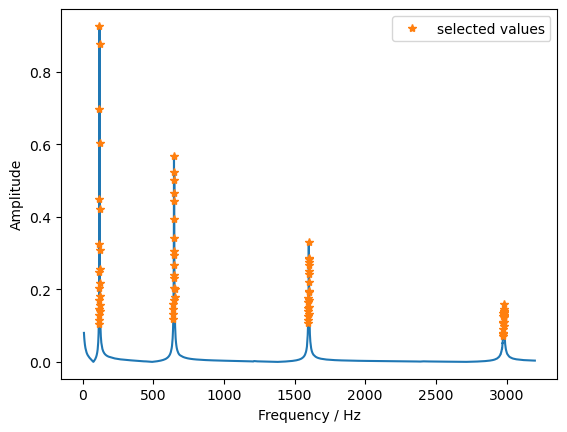

In [17]:
plt.plot(freq, Y_exp)
plt.plot(comsolArray,Y_exp[np.isin(freq, comsolArray)], '*', label="selected values")
plt.ylabel("Amplitude")
plt.xlabel("Frequency / Hz")
plt.legend()


In [67]:
import json

print(comsolArray)
with open('./frequencies.txt', 'w') as filehandle:
    json.dump(comsolArray.tolist(), filehandle)

[ 115.   115.5  116.   116.5  117.   117.5  118.   118.5  119.   119.5
  120.   120.5  121.   121.5  122.   122.5  123.   123.5  124.   124.5
  642.   642.5  643.   643.5  644.   644.5  645.   645.5  646.   646.5
  647.   647.5  648.   648.5  649.   649.5  650.   650.5  651.   651.5
 1595.5 1596.  1596.5 1597.  1597.5 1598.  1598.5 1599.  1599.5 1600.
 1600.5 1601.  1601.5 1602.  1602.5 1603.  1603.5 1604.  1604.5 1605.
 2974.5 2975.  2975.5 2976.  2976.5 2977.  2977.5 2978.  2978.5 2979.
 2979.5 2980.  2980.5 2981.  2981.5 2982.  2982.5 2983.  2983.5 2984. ]


In [46]:
np.savetxt('freq.txt', comsolArrayC, format='%.2e')

TypeError: _savetxt_dispatcher() got an unexpected keyword argument 'format'

In [50]:
comsolArrayC = str(comsolArrayC).replace("[", "(")
comsolArrayC = comsolArrayC.replace("]", ")")

In [51]:
comsolArrayC

'( 215.   215.5  216.   216.5  217.   217.5  218.   218.5  219.   219.5\n  220.   220.5  221.   221.5  222.   222.5  223.   223.5  224.   224.5\n 1269.  1269.5 1270.  1270.5 1271.  1271.5 1272.  1272.5 1273.  1273.5\n 1274.  1274.5 1275.  1275.5 1276.  1276.5 1277.  1277.5 1278.  1278.5\n 3176.  3176.5 3177.  3177.5 3178.  3178.5 3179.  3179.5 3180.  3180.5\n 3181.  3181.5 3182.  3182.5 3183.  3183.5 3184.  3184.5 3185.  3185.5\n 5934.  5934.5 5935.  5935.5 5936.  5936.5 5937.  5937.5 5938.  5938.5\n 5939.  5939.5 5940.  5940.5 5941.  5941.5 5942.  5942.5 5943.  5943.5)'